In [ ]:
!pip install langchain_openai
!pip install langchain-community
!pip install pypdf
!pip install faiss-cpu

# 1. 사용 환경 준비

In [ ]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("OpenAI API key 입력: ")

OpenAI API key 입력: ··········


# 2. 모델 초기화

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

model = ChatOpenAI(model="gpt-4o-mini")

# 3. 문서 로드

In [ ]:
from langchain.document_loaders import PyPDFLoader

# PDF 파일 로드. 파일의 경로 입력
loader = PyPDFLoader("/content/[2024 한권으로 OK 주식과 세금].pdf")

# 페이지 별 문서 로드
docs = loader.load()

print(docs)
print(len(docs))

[Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 0}, page_content=''), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 1}, page_content=''), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 2}, page_content='지난해 말 국내 상장법인 주식을 보유한 개인 투자자가 1,400만명을 넘어서는 등  \n국민들의 주식시장에 대한 관심이 크게 증가하였습니다.\n최근 일반 국민들의 주식투자에 대한 관심이 크게 증가했음에도 불구하고, 주식 투자  \n관련 세금문제 등 궁금한 사항에 대하여 도움을 줄 수 있는 안내책자 등은 시중에서  \n쉽게 찾아보기 어려운 게 현실입니다.\n이에 국세청에서는 주식 관련 각종 세금에 대한 납세자들의 이해를 높이고 납세의무  \n이행에 도움이 될 수 있도록 「주식과 세금」 책자를 처음으로 제작·발간하게 되었습니다.\n이번에 새롭게 출간하는 ‘주식과 세금’ 책자는 주식거래의 기초상식과 주식의 취득  \n부터 보유 및 처분시까지 단계별 세금문제를 총 76개의 문답형식으로 구성하는 한편, \n인포그래픽 등을 적극 활용하여 가독성을 제고하였으며, 구체적인 절세 꿀팁 및 자주 \n발생하는 실수 사례 등을 추가하여 활용성도 강화하였습니다.\n모쪼록, 이 책자가 주식등 관련 납세자들의 성실한 납세의무 이행에 기여할 수 있기를\n기대합니다.\n2024.  5\n국세청 자산과세국장\n머리말'), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 3}, page_content='본 책자에

In [ ]:
print(docs[50])

page_content='39
양도소득세 과세대상 출자지분은 주로 인적회사의 지분을 의미하며, 여기서 인적회사란 
사원 상호간의 결합 관계가 깊고 회사의 활동이 사원들의 인적 조건에 따라 이루어지는 
회사로 사원들이 공동 출자하고 경영에도 참여하며 책임도 함께 지는  
회사를 말합니다. 합명회사, 합자회사가 대표적인 인적회사에  
해당합니다.
참고참고
양도소득세 과세대상 '주식등'이란 주식 또는 출자지분을 말하며, 신주인수권과 일정한 
증권예탁증권(DR)이 포함됩니다.
국내주식등 및 국내에 주소 또는 거소를 둔 거주자가 양도한 국외주식등의 양도로 발생하는 
소득에 대하여 양도소득세가 과세됩니다.
가. 양도소득세 과세대상 주식등의 종류 및 구분
조금 더 알아보기
출자지분의 개념
양도소득세 과세대상인 '주식등'이란 주식 또는 출자지분을 말하며,  
신주인수권과 일정한 증권예탁증권(DR)이 포함됩니다.
아울러, 국외주식도 양도소득세 과세대상에 해당합니다.
14    양도소득세 과세대상인
          '주식등'의 범위는 어떻게 되나요?
제 2 절 주식등 양도소득 과세대상' metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 50}


# 4. chunking

- chunking은 긴 문서를 더 작고 관리하기 쉬운 부분들로 나누는 과정
- vectorDB에 chunk단위로 적재하게 된다
- chunking의 장점:
  - 검색 정확도 향상: 관련된 정보만 정확하게 검색 가능
  - 컨텍스트 제한: LLM이 처리할 수 있는 컨텍스트 길이 내에서 효율적으로 정보 처리
  - 유연한 검색: 필요한 부분만 선택적으로 검색 가능

- chunking 시 고려사항:
  - 청크 크기: 너무 작으면 문맥이 끊기고, 너무 크면 관련 정보 찾기 어려움
  - 중복: 일부 중복을 허용하여 문맥 유지 필요
  - 의미 단위: 가능한 의미가 완결된 단위로 분할




### 예시
**Q. "야근 식대는 얼마인가요?"**
- chunking 없이 전체 문서 검색시 -> 전체 문서가 검색됨
  -> 불필요한 정보가 너무 많이 포함됨
  -> LLM의 context 길이 제한에 걸릴 수 있음
```
[전체 문서가 검색됨]
안녕하세요. ABC 회사의 신입사원 매뉴얼입니다.
출근 시간은 오전 9시입니다...
점심시간은 12시부터...
퇴근 시간은 오후 6시입니다. 야근 시 팀장의 승인이 필요하며, 야근 식대는 1만원까지 지원됩니다.
회사 내 보안을 위해...
```

- chunking 후 검색 시 -> 정확히 필요한 정보만 찾을 수 있음 -> 문서 길이에 상관없이 필요한 부분 정확히 처리 가능
```
[관련 청크만 검색됨]
퇴근 시간은 오후 6시입니다. 야근 시 팀장의 승인이 필요하며, 야근 식대는 1만원까지 지원됩니다.
```

---

**Q. "회사의 식사 관련 규정을 알려주세요."**


- chunking된 경우 -> 관련 청크 조합 가능
```
[점심 관련 청크]
점심시간은 12시부터 1시까지입니다. 사내 식당 이용시 사원증을 필수로 지참해야 합니다.
[야근 식사 관련 청크]
야근 시 팀장의 승인이 필요하며, 야근 식대는 1만원까지 지원됩니다.
```





  

### CharacterTextSplitter
: 구분자(seperator)를 기준으로 split하여 chunk를 나누는 방법

- separator: 텍스트를 분할할때 사용할 구분자. 기본 "\n\n"
- chunk_size: 한 청크의 최대 길이
- chunk_overlap: 연속된 청크들간의 중복되는 문자 수
- length_function: 청크의 길이를 측정하는 함수. 기본적으로 python의 len() 함수 사용
- is_separator_regex: separator가 정규표현식인지 여부를 지정. True로 설정하면 정규표현식 패턴으로 인식.

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=100,
    chunk_overlap=10,
    length_function=len,
    is_separator_regex=False,
)

splits = text_splitter.split_documents(docs)

print(splits[0])

page_content='지난해 말 국내 상장법인 주식을 보유한 개인 투자자가 1,400만명을 넘어서는 등  
국민들의 주식시장에 대한 관심이 크게 증가하였습니다.
최근 일반 국민들의 주식투자에 대한 관심이 크게 증가했음에도 불구하고, 주식 투자  
관련 세금문제 등 궁금한 사항에 대하여 도움을 줄 수 있는 안내책자 등은 시중에서  
쉽게 찾아보기 어려운 게 현실입니다.
이에 국세청에서는 주식 관련 각종 세금에 대한 납세자들의 이해를 높이고 납세의무  
이행에 도움이 될 수 있도록 「주식과 세금」 책자를 처음으로 제작·발간하게 되었습니다.
이번에 새롭게 출간하는 ‘주식과 세금’ 책자는 주식거래의 기초상식과 주식의 취득  
부터 보유 및 처분시까지 단계별 세금문제를 총 76개의 문답형식으로 구성하는 한편, 
인포그래픽 등을 적극 활용하여 가독성을 제고하였으며, 구체적인 절세 꿀팁 및 자주 
발생하는 실수 사례 등을 추가하여 활용성도 강화하였습니다.
모쪼록, 이 책자가 주식등 관련 납세자들의 성실한 납세의무 이행에 기여할 수 있기를
기대합니다.
2024.  5
국세청 자산과세국장
머리말' metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 2}


Q. 왜 chunk간 overlap을 허용하나요?

overlap(중복)을 두는 것은 매우 중요한 이유가 있습니다:

1. **문맥 보존**
   - 텍스트를 단순히 자르면 문장이나 중요한 문맥이 끊길 수 있습니다
   - 예시:
     ```python
     # overlap이 없는 경우
     chunk1: "인공지능은 데이터를 기반으로"
     chunk2: "학습하여 결과를 도출합니다"
     
     # overlap이 있는 경우 (10자 중복)
     chunk1: "인공지능은 데이터를 기반으로 학습하여"
     chunk2: "기반으로 학습하여 결과를 도출합니다"
     ```

2. **정보의 연속성**
   - 특히 검색이나 QA 시스템에서 중요
   - 질문의 답이 청크의 경계에 걸쳐 있을 때 overlap이 없다면 정확한 답을 찾기 어려움
   - overlap이 있으면 관련 정보를 모두 포함하는 청크를 찾을 확률이 높아짐

3. **의미 단위 보존**
   - 키워드나 중요한 구문이 청크 경계에서 잘리는 것을 방지
   - 예를 들어 "머신러닝"이라는 단어가 두 청크로 나뉘면 의미가 손실됨

4. **검색 품질 향상**
   - 벡터 검색시 유사도 계산의 정확도 향상
   - 문맥이 보존되어 있어 더 관련성 높은 결과를 얻을 수 있음

다만, overlap 크기는 신중하게 선택해야 합니다:
- 너무 크면: 저장 공간 낭비, 중복 정보 과다
- 너무 작으면: 문맥 손실 가능성 증가
- 보통 chunk_size의 10~20% 정도를 overlap으로 설정하는 것이 일반적

### RecursiveCharacterTextSplitter
: 지정한 chunk_size 이하가 되도록 주어진 문자 목록의 순서대로 텍스트를 분할
- 기본 문자 목록은 ["\n\n", "\n", " ", ""]
- 기본적으로 ["\n\n", "\n", " ", ""]와 같은 문자를 이용해 자릅니다. 순서대로 가장 먼저 “\n\n”으로 자르고, 그래도 chunk_size 보다 긴 chunk는 “\n”으로 자르고, 그래도 길면 ” “로 자르는 방식으로 chunk를 만듭니다.
- 단순히 글자수로 자르는 것에 비해 문단, 문장, 단어 등으로 자르기 때문에 글의 의미를 보존하는데 좋은 방법

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

recursive_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len,
    is_separator_regex=False,
)

splits = recursive_text_splitter.split_documents(docs)
print(splits)
print(len(splits))
print(splits[0])

[Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 2}, page_content='지난해 말 국내 상장법인 주식을 보유한 개인 투자자가 1,400만명을 넘어서는 등  \n국민들의 주식시장에 대한 관심이 크게 증가하였습니다.'), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 2}, page_content='최근 일반 국민들의 주식투자에 대한 관심이 크게 증가했음에도 불구하고, 주식 투자  \n관련 세금문제 등 궁금한 사항에 대하여 도움을 줄 수 있는 안내책자 등은 시중에서'), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 2}, page_content='쉽게 찾아보기 어려운 게 현실입니다.\n이에 국세청에서는 주식 관련 각종 세금에 대한 납세자들의 이해를 높이고 납세의무'), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 2}, page_content='이행에 도움이 될 수 있도록 「주식과 세금」 책자를 처음으로 제작·발간하게 되었습니다.\n이번에 새롭게 출간하는 ‘주식과 세금’ 책자는 주식거래의 기초상식과 주식의 취득'), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 2}, page_content='부터 보유 및 처분시까지 단계별 세금문제를 총 76개의 문답형식으로 구성하는 한편, \n인포그래픽 등을 적극 활용하여 가독성을 제고하였으며, 구체적인 절세 꿀팁 및 자주'), Document(metadata={'sou

### chunking에 대한 추가자료
- [LLamaindex의 경험적 자료](https://www.llamaindex.ai/blog/evaluating-the-ideal-chunk-size-for-a-rag-system-using-llamaindex-6207e5d3fec5)

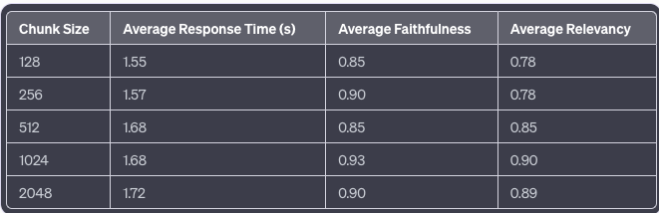


# 5. embedding 단계

- embedding: chunk를 “실수 벡터 형태”로 표현한 결과
- 왜 embedding을 하나요?
  - 컴퓨터는 청크 임베딩 간의 거리를 계산하여 이들 간의 의미적 관계를 이해할 수 있습니다.
  - 따라서 사용자가 입력한 질문(Query)에 대해 DB에 저장한 chunk를 검색해서 가져올때 유사도 계산을 기반으로 계산하기때문에 embedding하여 DB에 저장해둡니다.
  - 따라서 chunk한 결과들은 DB에 embedding하여 저장해둬야겠죠?

- 예시
  - "치타"와 "모니터"의 embedding값의 유사도 계산값 보다  
    "치타"와 의 "호랑이" embedding 값의 유사도 계산 값이 가깝습니다!
  - "치타"와 의 "호랑이"가 의미적으로 더 가깝기 때문이죠.
  

- [huggingface leaderboard](https://huggingface.co/spaces/mteb/leaderboard)에서 다양한 embedding model들의 순위를 확인할 수 있습니다.


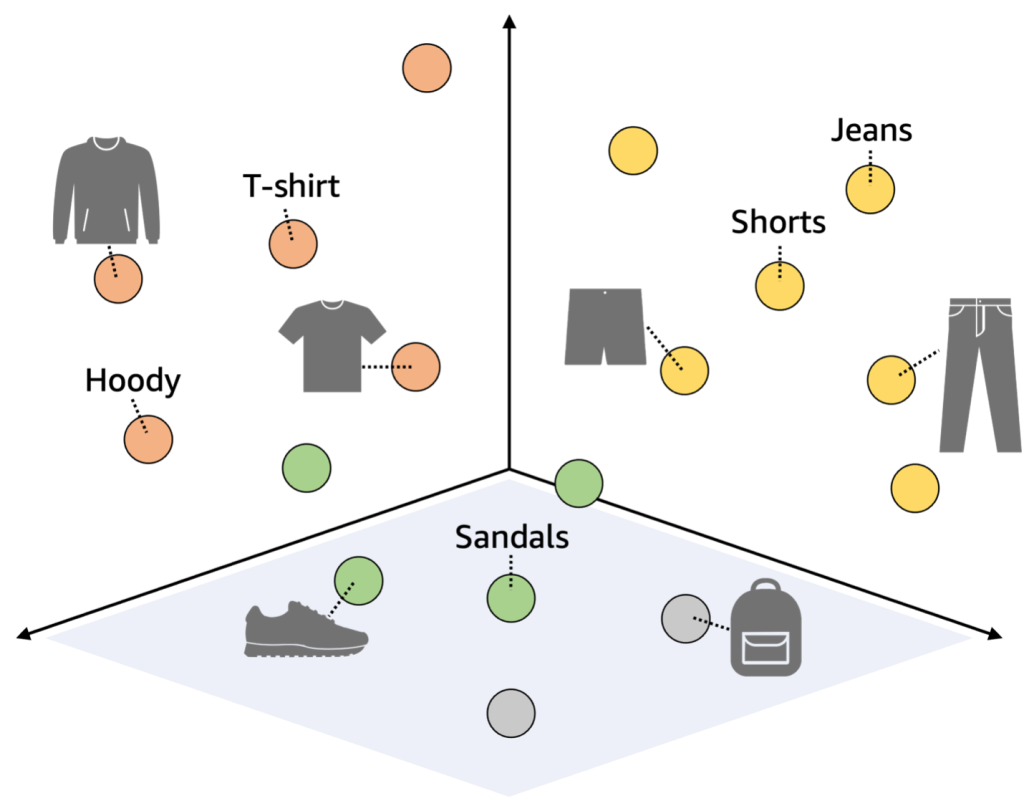

In [ ]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-ada-002") # 토큰화된 문서를 모델에 입력하여 임베딩 벡터를 생성하고, 이를 평균하여 전체 문서의 벡터를 생성

# 6. 벡터 스토어 생성

- 벡터 스토어: 이전 단계에서 생성된 임베딩 벡터들을 효율적으로 저장하고 관리하는 저장소

- 벡터 스토어의 특징
  - 빠른 검색 속도: 임베딩 벡터들을 효과적으로 저장하고 색인화함으로써, 대량의 데이터 중에서도 관련된 정보를 빠르게 검색할 수 있습니다.
  - 스케일러빌리티: 데이터가 지속적으로 증가함에 따라, 벡터스토어는 이를 수용할 수 있는 충분한 스케일러빌리티를 제공해야 합니다. 효율적인 저장 구조는 데이터베이스의 확장성을 보장하며, 시스템의 성능 저하 없이 대규모 데이터를 관리할 수 있도록 합니다.
  - 의미 검색(Semantic Search) 지원: 키워드 기반 검색이 아닌 사용자의 질문과 의미상으로 유사한 단락을 조회해야하는데, 벡터스토어는 이러한 기능을 지원합니다. 텍스트 자체가 저장되는 DB의 경우 키워드 기반 검색에 의존해야 하는 한계성이 있지만, **벡터스토어는 embedding 기반의 저장 및 검색을 통해
 의미적으로 유사한 단락 검색을 가능케**합니다.

 - 벡터 스토어로는 FAISS, pinecone, chroma등이 있습니다.

In [ ]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(documents=splits, embedding=embeddings)

# 7. Retriever 객체 생성


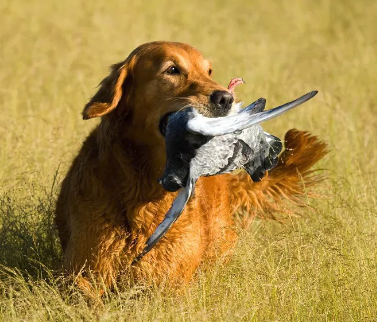

- 리트리버 : 물어오기! 저장된 벡터 데이터베이스에서 사용자의 질문과 관련된 문서를 검색(물어오기)하는 검색기

- 동작방식
  1. 질문의 vector embedding: 사용자의 질문을 벡터 형태로 변환합니다.
  
    `Q. 우리 회사의 사내 밥 시간 규정은 어떻게 돼? ---변환---> ['0.0038338393383393', '38383727829', .., '0.338292728']`

  2. vector 유사성 비교: 저장된 문서 벡터들과 질문 벡터 사이의 유사성을 계산합니다. 주로 벡터 간 코사인 유사도를 사용합니다.

      `['0.289478233', '3387497263874829', .., '0.87598742'] <---유사도 계산---> ['0.0038338393383393', '38383727829', .., '0.338292728']`

      `['0.5893475983749', '4859387495', .., '0.09804975983'] <---유사도 계산---> ['0.0038338393383393', '38383727829', .., '0.338292728']`
      ...


   3. 상위 문서 선정: 계산된 유사도 점수를 기준으로 상위 N개의 가장 관련성 높은 문서를 선정합니다. 보통 top-k 라는 파라미터를 사용합니다. 이 top-k개의 문서들은 다음 단계에서 사용자의 질문에 대한 답변을 생성하는 데 사용됩니다.

    `top 2개의 문서는 아래와 같습니다!`

    `사칙 3873조. 우리 회사의 점심 시간은 12:30 ~ 1:30 입니다.`

    `사칙 96887858483조. 우리 회사의 석식 시간은 18:00 ~ 19:00 입니다.`


  4. 문서 정보 반환: 선정된 top-k개의 문서들은 다음 단계(프롬프트 생성)로 전달합니다.

    ```
    prompt
    system: 아래 내용을 기반으로만 대답해줘.
    맥락: 사칙 3873조. 우리 회사의 점심 시간은 12:30 ~ 1:30 입니다.
    사칙 96887858483조. 우리 회사의 석식 시간은 18:00 ~ 19:00 입니다.
    질문 : 우리 회사의 사내 밥 시간 규정은 어떻게 돼?
    ```
    

In [ ]:
from langchain.vectorstores.base import VectorStore

retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 10})

# 8. 프롬프트 템플릿 정의

```
system: 아래 내용을 기반으로만 대답해줘.
user : 맥락: 사칙 3873조. 우리 회사의 점심 시간은 12:30 ~ 1:30 입니다.
사칙 96887858483조. 우리 회사의 석식 시간은 18:00 ~ 19:00 입니다.
질문 : 우리 회사의 사내 밥 시간 규정은 어떻게 돼?

```

위와 같은 내용을 늘 쓰기 위해서 템플릿화 하려면 어떻게 해야할까?

langchain에서 제공하는 ChatPromptTemplate를 활용하면 됩니다!

```
system: 아래 내용을 기반으로만 대답해줘.
user : 맥락: {리트리버가 검색해온 context}
질문 : {사용자가 입력한 질문 question}
```

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

# 프롬프트 템플릿 정의
contextual_prompt = ChatPromptTemplate.from_messages([
    ("system", "Answer the question using only the following context."),
    ("user", "Context: {context}\\n\\nQuestion: {question}")
])

# 9. RAG 체인 구성

In [ ]:
# 디버깅을 위해 만든 클래스 (신경쓰지 않으셔도 됩니다.)
class SimplePassThrough:
    def invoke(self, inputs, **kwargs):
        return inputs

# 프롬프트 클래스
class ContextToPrompt:
    def __init__(self, prompt_template):
        self.prompt_template = prompt_template

    def invoke(self, inputs):
        # response_docs 내용을 trim해줌 (가독성을 높여줌)
        if isinstance(inputs, list): # inputs가 list인 경우. 즉 여러개의 문서들이 검색되어 리스트로 전달된 경우
            context_text = "\n".join([doc.page_content for doc in inputs]) # \n을 구분자로 넣어서 한 문자열로 합쳐줌
        else:
            context_text = inputs # 리스트가 아닌경우는 그냥 리턴해줌

        # 프롬프트
        formatted_prompt = self.prompt_template.format_messages( # 템플릿의 변수에 삽입해줌
            context=context_text, # {context} 변수에 context_text, 즉 검색된 문서 내용을 삽입함
            question=inputs.get("question", "")
        )
        return formatted_prompt

# Retriever 클래스
class RetrieverWrapper:
    def __init__(self, retriever):
        self.retriever = retriever

    def invoke(self, inputs):
        # 0단계 : query의 타입에 따른 전처리
        if isinstance(inputs, dict): # inputs가 딕셔너리 타입일경우, question 키의 값을 검색 쿼리로 사용
            query = inputs.get("question", "")
        else: # 질문이 문자열로 주어지면, 그대로 검색 쿼리로 사용
            query = inputs
        # 1단계 : query를 리트리버에 넣어주고, response_docs를 얻어모
        response_docs = self.retriever.get_relevant_documents(query) # 검색을 수행하고 검색 결과를 response_docs에 저장
        return response_docs

# RAG 체인 설정
rag_chain_debug = {
    "context": RetrieverWrapper(retriever), # 클래스 객체를 생성해서 value로 넣어줌
    "prompt": ContextToPrompt(contextual_prompt),
    "llm": model
}

# 10. 챗봇 구동 확인

In [ ]:
# 챗봇 구동
while True:
    print("========================")

    # 0. 질문을 받아서 query에 저장함
    query = input("질문을 입력하세요 : ")

    # 1. 리트리버로 question에 대한 검색 결과를 response_docs에 저장함
    response_docs = rag_chain_debug["context"].invoke({"question": query})

    # 2. 프롬프트에 질문과 response_docs를 넣어줌
    prompt_messages = rag_chain_debug["prompt"].invoke({
        "context": response_docs,
        "question": query
    })

    # 3. 완성된 프롬프트를 LLM에 넣어줌
    response = rag_chain_debug["llm"].invoke(prompt_messages)

    print("\n답변:")
    print(response.content)

질문을 입력하세요 : 주식이 뭐야?
[SystemMessage(content='Answer the question using only the following context.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Context: {\'context\': [Document(metadata={\'source\': \'/content/[2024 한권으로 OK 주식과 세금].pdf\', \'page\': 39}, page_content=\'금융투자상품이란 무엇인가요?\'), Document(metadata={\'source\': \'/content/[2024 한권으로 OK 주식과 세금].pdf\', \'page\': 63}, page_content=\'대주주만 해당되나요?\\n제 3 절 상장주식 양도소득세 과세대상 대주주\'), Document(metadata={\'source\': \'/content/[2024 한권으로 OK 주식과 세금].pdf\', \'page\': 4}, page_content=\'주식등 과세이해를 위한 기초지식\\n주식등 양도소득의 이해\\n 1.\\n 2 .\\n 3.\\n 4.\\n 5.\\n 6.\\n 7.\\n 8.\\n 9.\\n10.\\n \\n11.\\n12.\\n주식의 개념과 종류가 궁금해요\'), Document(metadata={\'source\': \'/content/[2024 한권으로 OK 주식과 세금].pdf\', \'page\': 14}, page_content=\'가. 주식의 개념\\n주식이란 주식회사를 설립하거나 사업확장 등을 위해 필요한 자금을 \\n조달할 때 투자자에게 자금을 보탠 대가로 발행해 주는 증서로서 주식\'), Document(metadata={\'source\': \'/content/[2024 한권으로 OK 주

KeyboardInterrupt: Interrupted by user